### 1. Install Package

In [345]:
%pip install albumentations

In [346]:
%pip install torchvision
%pip install open
%pip install pycocotools



Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement open (from versions: none)
ERROR: No matching distribution found for open


Note: you may need to restart the kernel to use updated packages.


### Import Library

In [347]:
import numpy as np
import pandas as pd
import os
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import  functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A # data augmentation library
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import  tqdm #  progress bar
from torchvision.utils import  draw_bounding_boxes
from pycocotools.coco import COCO
from albumentations.pytorch import ToTensorV2
import sys

In [348]:
print (torch.__version__)
print (torchvision.__version__)

2.5.1+cpu
0.20.1+cpu


### Dataset

In [349]:
def get_transforms(train=False):
    if train:
        transorm = A.Compose([
            A.LongestMaxSize(max_size=1000), # Resize the input image to 413x1000
            A.PadIfNeeded(min_height=413, min_width=1000), # Add extra padding if needed
            A.HorizontalFlip(p=0.3), # Horizontally flip the image with a probability of 30%
            A.VerticalFlip(p=0.3), # Vertically flip the image with a probability of 30%
            A.RandomBrightnessContrast(p=0.1), # Randomly change brightness and contrast of the image with a probability of 10%
            A.ColorJitter(p=0.1), # Randomly change the brightness, contrast, and saturation of an image with a probability of 10%
             A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalize
            ToTensorV2() # Convert the image to PyTorch tensor
        ], bbox_params=A.BboxParams(format='coco')) # Define the format of the bounding boxes
    else:
        transorm = A.Compose([
            A.Resize(413, 1000),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))

    return transorm
            

In [350]:
class LicensePlateDataset(datasets.VisionDataset): # subclass of datasets.VisionDataset
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # root: the root directory where the dataset is stored
        super().__init__(root, transforms, transform, target_transform)
        self.split = split # train, valid, test
        self.coco = COCO(os.path.join(root, split, "annotations.json")) # annotations stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        
        boxes = [t['bbox'] + [t['category_id']] for t in target]  # xywh + class label

        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
            image = transformed['image']
            boxes = transformed['bboxes']
            
            new_boxes = []
            for box in boxes:
                xmin = box[0]
                ymin = box[1]
                xmax = xmin + box[2]  # Ensure width ≥ 1
                ymax = ymin + box[3]  # Ensure height ≥ 1
                new_boxes.append([xmin, ymin, xmax, ymax])

            boxes = torch.tensor(new_boxes, dtype=torch.float32)

            targ = {}  # Target dictionary
            targ['boxes'] = boxes
            targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
            targ['image_id'] = torch.tensor([t['image_id'] for t in target])
            targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])  
            targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)

            return image.div(255), targ  # Normalize the image
        else:
            return image, target


    
    def __len__(self):
        return len(self.ids)

In [351]:
dataset_path ="D:/Projects/VehicleDetectModel"

In [352]:
#load classes
coco = COCO(os.path.join(dataset_path, "train/annotations.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories



loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


{0: {'id': 0, 'name': 'Background'}, 1: {'id': 1, 'name': 'LicensePlate'}}

In [353]:
classes = [i[1]['name'] for i in categories.items()]
classes

['Background', 'LicensePlate']

### Training

In [354]:
train_dataset = LicensePlateDataset(root=dataset_path, split="train", transforms=get_transforms(True))


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


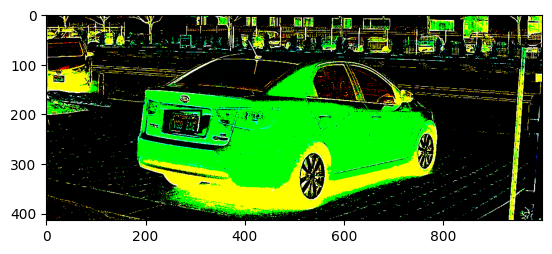

In [355]:
# Sample
sample = train_dataset[2]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
# Ensure the number of labels matches the number of boxes
labels = [classes[i] for i in sample[1]['labels'].tolist()] * len(sample[1]['boxes'])

plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], labels, width=4
).permute(1, 2, 0))

In [356]:
len(train_dataset)

385


Our model is FasterRCNN with a backbone of resnet50


In [357]:

# Load the faster rcnn model
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # number of input features for the box predictor
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)
print(model.rpn)


RegionProposalNetwork(
  (anchor_generator): AnchorGenerator()
  (head): RPNHead(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (cls_logits): Conv2d(256, 15, kernel_size=(1, 1), stride=(1, 1))
    (bbox_pred): Conv2d(256, 60, kernel_size=(1, 1), stride=(1, 1))
  )
)


This is our collating function for the train dataloader, it allows us to create batches of data that can be easily pass into the model


In [358]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [359]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0, collate_fn=collate_fn)

The following blocks ensures that the model can take in the data and that it will not crash during training


In [360]:
images, targets = next(iter(train_loader))
images = list(image for image in images)

# Filter out invalid bounding boxes
for target in targets:
	valid_boxes = []
	valid_labels = []
	for box, label in zip(target['boxes'], target['labels']):
		xmin, ymin, xmax, ymax = box
		if xmax > xmin and ymax > ymin:  # Check for positive width and height
			valid_boxes.append(box)
			valid_labels.append(label)
	target['boxes'] = torch.stack(valid_boxes) if valid_boxes else torch.empty((0, 4), dtype=torch.float32)
	target['labels'] = torch.tensor(valid_labels, dtype=torch.int64) if valid_labels else torch.empty((0,), dtype=torch.int64)

output = model(images, targets)  # Just make sure this runs without error


In [361]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print('done')

done


Optimizer:

Here, we define the optimizer.



In [362]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)

Training:

The following is a function that will train the model for one epoch. Torchvision Object Detections models have a loss function built in, and it will calculate the loss automatically if you pass in the inputs and targets

In [363]:

def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()
    
    all_losses = []
    all_losses_dict = []
    
    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets) # get the loss dictionary
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()
        
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
        
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    # epoch wise mean loss
    epoch_loss = np.mean(all_losses)
    
    # Convert list of dicts to DataFrame and compute mean loss per key
    if all_losses_dict:
        all_losses_frame = pd.DataFrame(all_losses_dict)
        epoch_losses_dict = all_losses_frame.mean().to_dict()
    else:
        epoch_losses_dict = {}

    # Print losses
    print("Epoch {}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, 
        epoch_loss,
        epoch_losses_dict.get('loss_classifier', 0),
        epoch_losses_dict.get('loss_box_reg', 0),
        epoch_losses_dict.get('loss_rpn_box_reg', 0),
        epoch_losses_dict.get('loss_objectness', 0)
    ))

    return epoch_loss, epoch_losses_dict

10 Epochs should be enough to train this model for a high accuracy

In [364]:
num_epochs= 10
train_losses = []
loss_classifier = []
loss_box_reg = []
loss_rpn_box = []
loss_objectness = []

for epoch in range(num_epochs):
    epoch_loss, epoch_losses_dict = train_one_epoch(model, optimizer, train_loader, device, epoch)

    # Store total and individual losses
    train_losses.append(epoch_loss)
    loss_classifier.append(epoch_losses_dict['loss_classifier'])
    loss_box_reg.append(epoch_losses_dict['loss_box_reg'])
    loss_rpn_box.append(epoch_losses_dict['loss_rpn_box_reg'])
    loss_objectness.append(epoch_losses_dict['loss_objectness'])

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Total Loss", marker="o", linestyle="-")
plt.plot(loss_classifier, label="Classification Loss", marker="s", linestyle="--")
plt.plot(loss_box_reg, label="Box Regression Loss", marker="^", linestyle="-.")
plt.plot(loss_rpn_box, label="RPN Box Loss", marker="v", linestyle=":")
plt.plot(loss_objectness, label="Objectness Loss", marker="x", linestyle="-.")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Trends Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

 57%|█████▋    | 55/97 [05:22<04:06,  5.86s/it]

Loss is nan, stopping trainig
{'loss_classifier': tensor(nan, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(nan, grad_fn=<DivBackward0>), 'loss_objectness': tensor(nan, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(nan, grad_fn=<DivBackward0>)}


SystemExit: 1


### Trying on sample Images

This is the inference code for the model. First, we set the model to evaluation mode and clear the GPU Cache. We also load a test dataset, so that we can use fresh images that the model hasn't seen.


In [ ]:
model.eval()
torch.cuda.empty_cache()

In [ ]:
test_dataset = LicensePlateDataset(root=dataset_path, split="valid", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [ ]:
img, _ = test_dataset[9]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]
    print(pred)

{'boxes': tensor([[329.7162, 194.4363, 366.8236, 225.1057],
        [367.5572, 202.3475, 396.6504, 222.3803],
        [355.8283, 199.9566, 406.4292, 226.9492],
        [370.1674, 201.2693, 395.6460, 210.7362],
        [336.1548, 197.0354, 364.7993, 214.9501]]), 'labels': tensor([1, 1, 1, 1, 1]), 'scores': tensor([0.8443, 0.1138, 0.1112, 0.0935, 0.0773])}


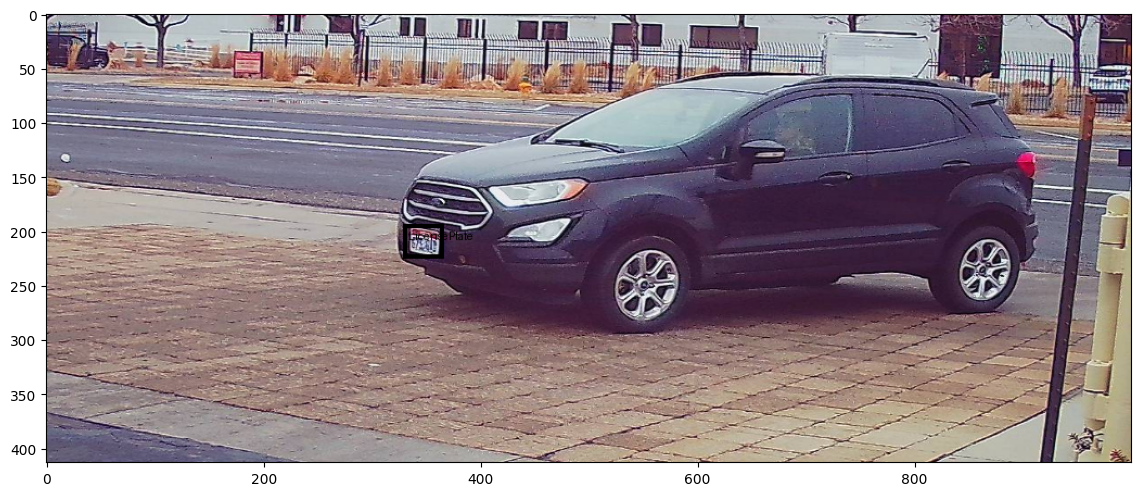

In [ ]:


fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.6],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.6].tolist()], width=4
).permute(1, 2, 0))



In [ ]:
torch.save(model, 'model_lecense_plate_detection.pth')

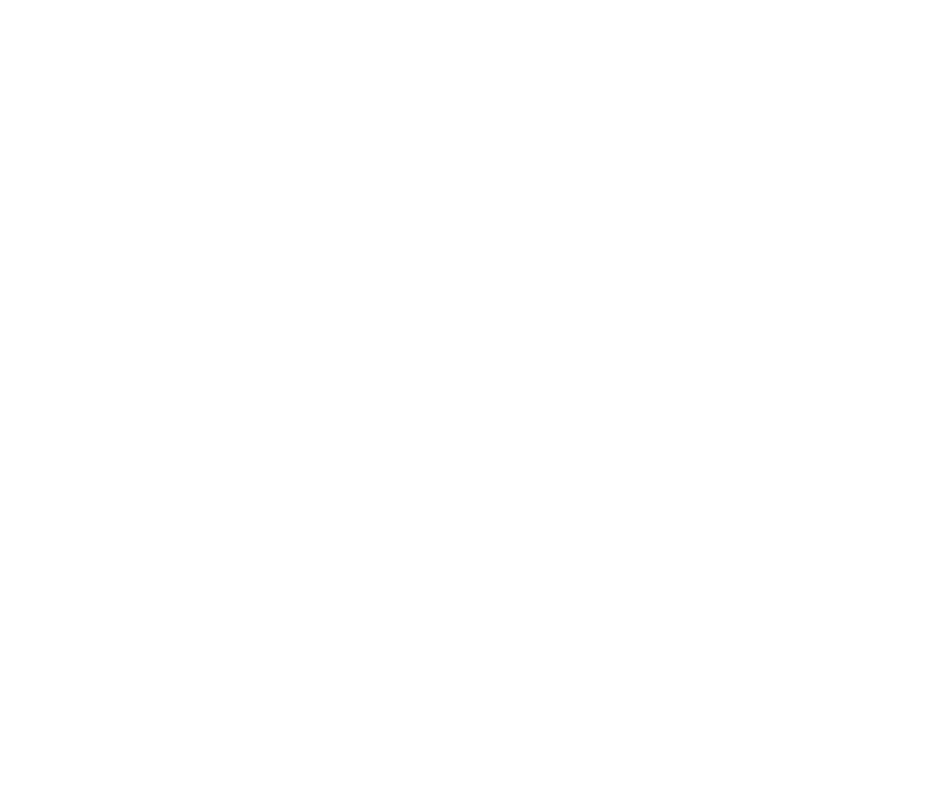

In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from PIL import Image

# Load Faster R-CNN with ResNet-50 backbone
def get_model(num_classes):
    # Load pre-trained Faster R-CNN
    model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    return model


# Initialize the model
num_classes = 2 

# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


# Load the trained model
model = get_model(num_classes)
model = torch.load("model_lecense_plate_detection.pth")
model.to(device)
model.eval()  # Set the model to evaluation mode


def prepare_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Open image
    image_tensor = F.to_tensor(image).unsqueeze(0)  # Convert image to tensor and add batch dimension
    return image_tensor.to(device)



# Load the unseen image
image_path = "test/9fd08d7e-30d2-471b-907b-ab030b3f2eff.jpeg"
image_tensor = prepare_image(image_path)

with torch.no_grad():  # Disable gradient computation for inference
    prediction = model(image_tensor)

# `prediction` contains:
# - boxes: predicted bounding boxes
# - labels: predicted class labels
# - scores: predicted scores for each box (confidence level)
COCO_CLASSES = {1: "LicensePlate"}

def get_class_name(class_id):
    return COCO_CLASSES.get(class_id, "Background")
    
# Draw bounding boxes with the correct class names and increase image size
def draw_boxes(image, prediction, fig_size=(10, 10)):
    boxes = prediction[0]['boxes'].cpu().numpy()  # Get predicted bounding boxes
    labels = prediction[0]['labels'].cpu().numpy()  # Get predicted labels
    scores = prediction[0]['scores'].cpu().numpy()  # Get predicted scores
    
    # Set a threshold for showing boxes (e.g., score > 0.5)
    threshold = 0.5
    
    # Set up the figure size to control the image size
    plt.figure(figsize=fig_size)  # Adjust the figure size here

    for box, label, score in zip(boxes, labels, scores):
        if score > threshold:
            x_min, y_min, x_max, y_max = box
            class_name = get_class_name(label)  # Get the class name
            plt.imshow(image)  # Display the image
            plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                              linewidth=2, edgecolor='r', facecolor='none'))
            plt.text(x_min, y_min, f"{class_name} ({score:.2f})", color='r')
    
    plt.axis('off')  # Turn off axis
    plt.show()

# Display the image with bounding boxes and correct labels
draw_boxes(Image.open(image_path), prediction, fig_size=(12, 10))  # Example of increased size

## mAP

In [ ]:
# import torch
# import torchvision
# from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchmetrics.detection.mean_ap import MeanAveragePrecision
# from torchvision.transforms import functional as F
# from torch.utils.data import DataLoader


# 
# Define metric
metric = MeanAveragePrecision(iou_thresholds=[0.5, 0.75])  # COCO-style IoU

# Evaluate Model on Test Dataset
with torch.no_grad():
    for images, targets in test_dataset:
        images = [img.unsqueeze(0) if len(img.shape) == 2 else img for img in images]  # Ensure each image is 3D
        outputs = model(images)  # Run inference

        # Convert predictions to required format
        predictions = [{
            "boxes": outputs[0]["boxes"].detach().cpu(),
            "scores": outputs[0]["scores"].detach().cpu(),
            "labels": outputs[0]["labels"].detach().cpu()
        }]

        # Convert ground truths to required format
        ground_truths = [{
            "boxes": targets["boxes"],
            "labels": targets["labels"]
        }]

        # Update metric
        metric.update(predictions, ground_truths)

# Compute final mAP
result = metric.compute()
print("mAP@0.5:", result["map_50"])
print("mAP@0.5:0.95:", result["map"])


mAP@0.5: tensor(0.2791)
mAP@0.5:0.95: tensor(0.1836)
